In [4]:
import pandas as pd
import ijson
import numpy as np
import json
import io
import os
import matplotlib.pyplot as plt

In [5]:
## We choose data from Las Vegas as an illustrative example.

data = pd.read_csv('LasVegas_tips_after2017.csv')

In [6]:
data.head(5)

,Unnamed: 0,business_id,text,date,attributes,categories,city,name,stars,review_count
0,8,KPgyqG3MyFUDK7GRbUg51A,Kelly Paun was so full of knowledge and was so...,2017-03-23,NaN,"Landmarks & Historical Buildings, Travel Servi...",Las Vegas,Pink Jeep Tours,4.5,136
1,20,JtNVcqioJhS8GZ-If30oHg,Make sure you sign up for Emerald club before ...,2018-03-29,NaN,"Automotive, Hotels & Travel, Car Rental",Las Vegas,National Car Rental,4.0,224
2,34,gh6__q2WXFuyN8gt6VAnWw,Very delicious food with very fast delivery!,2017-09-24,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189
3,55,gh6__q2WXFuyN8gt6VAnWw,Amazing Portuguese food! Linguica (chirizo) is...,2017-12-11,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189
4,56,gh6__q2WXFuyN8gt6VAnWw,All the way from Porto portugal lost off love!...,2018-04-10,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189


In [7]:
data.dtypes

Unnamed: 0        int64
business_id      object
text             object
date             object
attributes       object
categories       object
city             object
name             object
stars           float64
review_count      int64
dtype: object

## Define a categorical variable

In [8]:
data.index

RangeIndex(start=0, stop=65280, step=1)

In [9]:
stars = np.array(data['stars'])

In [10]:
##1.0 means good; 0.0 means not good, bad ...
stars[stars<4.0] = 0.0
stars[stars>=4.0] = 1.0
data['class'] = stars

In [11]:
data.head(15);

In [12]:
data[data['stars'].astype('float64')<4.0].count()

Unnamed: 0      21364
business_id     21364
text            21364
date            21364
attributes      20527
categories      21348
city            21364
name            21364
stars           21364
review_count    21364
class           21364
dtype: int64

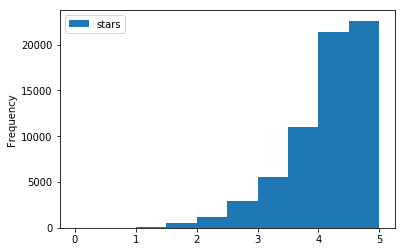

In [13]:
data[['stars']].astype('float64').plot(kind='hist',bins=[0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
plt.show()

### A glimpse onto the statistics of the class variable

In [14]:
data['stars'].describe()

count    65280.000000
mean         3.908058
std          0.703868
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: stars, dtype: float64

In [15]:
data['class'].describe()

count    65280.000000
mean         0.672733
std          0.469219
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: class, dtype: float64

### Combine the tips column with the stars column

In [16]:
# Create a new column which combines "text" and "stars"

# Turn stars into strings, add a space in front of each item

data['stars'] = data['stars'].map(str).apply(lambda x: ' ' + x);

data['tips_stars'] = data["text"] + data['stars']

In [17]:
data.iloc[98]['tips_stars']

"Park valet. It'll be the best $20 you spend because it gives you free valet parking nearly everywhere else (like Bellagio). Any MGM resort on the Strip is included, and there's many. 3.0"

### Split the dataset into training set and test set 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_set, test_set = train_test_split(
...     data, test_size=0.33, random_state=42)

### tf-idf

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =  TfidfVectorizer(max_features=1200,stop_words='english',ngram_range=(1,3))

In [21]:
vectorizer.fit(data['tips_stars'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1200, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
## The train set are tf-idfed.

train_tfidf = vectorizer.transform(train_set['tips_stars'].values.astype('U'))

In [23]:
test_tfidf = vectorizer.transform(test_set['tips_stars'].values.astype('U'))

In [24]:
train_tfidf.shape

(43737, 1200)

In [25]:
test_tfidf.shape

(21543, 1200)

In [26]:
#print(vectorizer.get_feature_names())

In [27]:
#print(test_tfidf)

In [28]:
vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### K Means

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn_pandas import DataFrameMapper

## The output of K_Means is an array of labels. 

In [30]:
K = 16
KMeans_model = KMeans(n_clusters=K, init='k-means++', max_iter=100, n_init=1)
KMeans_model.fit(train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=16, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
KMeans_model.predict(train_tfidf)

array([11,  8,  8, ...,  8,  6, 12], dtype=int32)

In [32]:
order_centroids = KMeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(K):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 excellent
 excellent service
 service
 food
 excellent food
 service excellent
 food excellent
 great
 food excellent service
 good
Cluster 1:
 sandwich
 chicken
 best
 cheese
 good
 egg
 grilled
 great
 breakfast
 salad
Cluster 2:
 ask
 best
 great
 server
 just
 make
 don
 sure
 awesome
 make sure
Cluster 3:
 customer
 customer service
 service
 great customer
 great customer service
 great
 food
 good customer
 good customer service
 customer service great
Cluster 4:
 delicious
 food
 delicious food
 food delicious
 great
 place
 service
 fresh
 love
 amazing
Cluster 5:
 try
 place
 good
 amazing
 great
 food
 love
 delicious
 best
 chicken
Cluster 6:
 amazing
 food
 amazing food
 food amazing
 service
 place
 amazing service
 great
 place amazing
 love
Cluster 7:
 bartender
 best
 great
 bar
 awesome
 nice
 drink
 love
 place
 drinks
Cluster 8:
 best
 place
 love
 awesome
 food
 don
 vegas
 time
 service
 just
Cluster 9:
 good
 food good
 good service
 food
 service
 fo

## Dimension Reducing: PCA

In [33]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

n_components = 50

#truncatedSVD 

In [34]:
svd = TruncatedSVD(n_components)

In [35]:
svd.fit(train_tfidf)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [36]:
svd.transform(train_tfidf)

array([[ 1.54680750e-01,  2.21570954e-01,  3.85020898e-01, ...,
         1.00958100e-02, -2.18156348e-01,  5.03832992e-03],
       [ 3.89008846e-02,  2.52412756e-02,  5.06765177e-03, ...,
         2.09436013e-02,  7.06972050e-03,  3.76464232e-02],
       [ 9.43313311e-03,  4.42738200e-03,  3.26915695e-04, ...,
        -8.83239877e-03, -3.39619059e-03,  1.31714563e-02],
       ...,
       [ 4.55152265e-02,  9.14737052e-03, -5.32351258e-03, ...,
         7.43914493e-02,  3.73746258e-03, -4.06769904e-02],
       [ 1.22982711e-01,  1.73236725e-01, -7.08136845e-02, ...,
         8.90677929e-02,  1.35773162e-01, -7.60425227e-03],
       [ 5.13250947e-02,  2.03377139e-02, -1.81862209e-03, ...,
        -8.14374889e-02, -9.90417548e-02,  1.96246592e-02]])

In [37]:
svd.fit_transform(train_tfidf)

array([[ 1.54681618e-01,  2.21545087e-01,  3.84989785e-01, ...,
        -8.69804973e-02, -1.14741322e-01,  1.35600514e-01],
       [ 3.89007312e-02,  2.52449492e-02,  5.07049993e-03, ...,
         1.51952366e-02,  5.65501329e-03,  8.40206186e-03],
       [ 9.43303822e-03,  4.42659701e-03,  3.26547623e-04, ...,
         7.01536913e-03,  2.70197493e-02, -8.98033845e-03],
       ...,
       [ 4.55153456e-02,  9.15120467e-03, -5.31696709e-03, ...,
        -5.67064281e-02, -6.48061060e-02,  3.60511518e-02],
       [ 1.22982552e-01,  1.73211214e-01, -7.08320326e-02, ...,
        -1.04222131e-01,  1.46853971e-01, -2.82511368e-02],
       [ 5.13250438e-02,  2.03388033e-02, -1.82876295e-03, ...,
        -7.97344708e-02,  4.23222068e-02,  1.31555048e-02]])

In [38]:
train_tfidf

<43737x1200 sparse matrix of type '<class 'numpy.float64'>'
	with 231554 stored elements in Compressed Sparse Row format>

In [39]:
# Import metrics functions
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [40]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [41]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred) 
#"Note: this implementation is restricted to the binary classification task."

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 3
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='brown', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
train_target = train_set["class"]

In [44]:
clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(train_tfidf,train_target)

In [45]:
clf.predict(train_tfidf)

array([1., 1., 1., ..., 1., 1., 0.])

In [46]:
clf.predict(test_tfidf)

array([1., 1., 1., ..., 1., 1., 0.])

In [47]:
clf.score(train_tfidf, train_target)

0.7227747673594439

In [48]:
clf.score(test_tfidf,test_set["class"])

0.700505964814557

In [49]:
train_set.count()

Unnamed: 0      43737
business_id     43737
text            43736
date            43737
attributes      42609
categories      43722
city            43737
name            43737
stars           43737
review_count    43737
class           43737
tips_stars      43736
dtype: int64

In [50]:
train_set[train_set["class"]==1.0].count()

Unnamed: 0      29505
business_id     29505
text            29504
date            29505
attributes      28946
categories      29501
city            29505
name            29505
stars           29505
review_count    29505
class           29505
tips_stars      29504
dtype: int64

In [51]:
29505/43737

0.6746004527059469

              train      test
metrics                      
AUC        0.617106  0.592998
Accuracy   0.722775  0.700506
Precision  0.735552  0.717423
Recall     0.919709  0.911179
f1-score   0.817386  0.802776


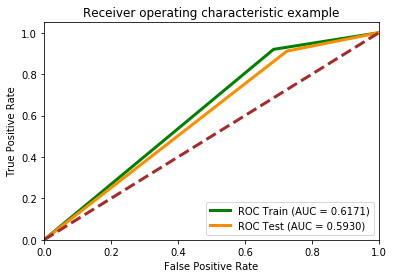

In [52]:
get_performance_metrics(train_target, clf.predict(train_tfidf), test_set["class"], clf.predict(test_tfidf), threshold=0.5)
plot_roc_curve(train_target, clf.predict(train_tfidf), test_set["class"], clf.predict(test_tfidf))

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
RF_clf = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=42)

In [65]:
RF_clf.fit(train_tfidf,train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [66]:
RF_clf.score(train_tfidf,train_target)

0.678052907149553

In [67]:
RF_clf.score(test_tfidf,test_set["class"])

0.6709836141670148

              train      test
metrics                      
AUC        0.505450  0.503297
Accuracy   0.678053  0.670984
Precision  0.677003  0.670405
Recall     0.999729  0.999584
f1-score   0.807308  0.802552


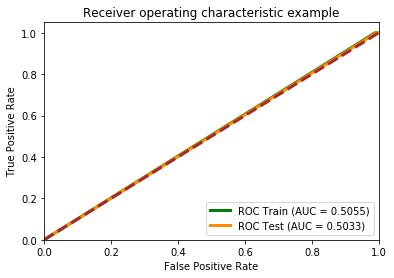

In [70]:
get_performance_metrics(train_target, RF_clf.predict(train_tfidf), test_set["class"], RF_clf.predict(test_tfidf), threshold=0.5)
plot_roc_curve(train_target, RF_clf.predict(train_tfidf), test_set["class"], RF_clf.predict(test_tfidf))

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

documents = ["This little kitty came to play when I was eating at a restaurant.",
             "Merley has the best squooshy kitten belly.",
             "Google Translate app is incredible.",
             "If you open 100 tab in google you get a smiley face.",
             "Best cat photo I've ever taken.",
             "Climbing ninja cat.",
             "Impressed with google map feedback.",
             "Key promoter extension for Google Chrome."]

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)


 

In [60]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
print("Top terms per cluster:")


Top terms per cluster:


In [62]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print



Cluster 0:
 google
 ninja
 climbing
 impressed
 incredible
 translate
 map
 feedback
 app
 cat
Cluster 1:
 best
 google
 chrome
 extension
 promoter
 key
 ve
 taken
 photo
 merley


In [63]:
print("\n")
print("Prediction")

Y = vectorizer.transform(["chrome browser to open."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["My cat is hungry."])
prediction = model.predict(Y)
print(prediction)



Prediction
[1]
[0]
